# Econ 323 Final Project

### Author: Anson Su

## Introduction

Safety is always the most concerning problem to people. This project will aim to visulize and predict the future crime events in Vancouver based on the exisiting dataset which from 2003 to 2023.

Outline of the project:
- Dataset Preprocessing
- Visualization
- Model Building and Analyzing
- Conclusion

## Packages

In [75]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import math

## Dataset Preprocessing

This project will use [Vancouver Crime Data between 2003 and 2023](https://www.kaggle.com/datasets/tcashion/vancouver-bc-crime-dataset/) dataset. Before we get into the topic, we need to preprocess the dataset. As this project focus on predicting the event counts for each crime type, columns like `MINUTE`, `NEIGHBOUR` are unnecessary to keep for further purpose.

In [76]:
df = pd.read_csv('crimedata_csv_AllNeighbourhoods_AllYears.csv')

In [77]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881242 entries, 0 to 881241
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   TYPE           881242 non-null  object 
 1   YEAR           881242 non-null  int64  
 2   MONTH          881242 non-null  int64  
 3   DAY            881242 non-null  int64  
 4   HOUR           881242 non-null  int64  
 5   MINUTE         881242 non-null  int64  
 6   HUNDRED_BLOCK  881230 non-null  object 
 7   NEIGHBOURHOOD  881099 non-null  object 
 8   X              881167 non-null  float64
 9   Y              881167 non-null  float64
dtypes: float64(2), int64(5), object(3)
memory usage: 67.2+ MB


In [78]:
df.head()

,TYPE,YEAR,MONTH,DAY,HOUR,MINUTE,HUNDRED_BLOCK,NEIGHBOURHOOD,X,Y
0,Break and Enter Commercial,2012,12,14,8,52,NaN,Oakridge,491285.0000,5.453433e+06
1,Break and Enter Commercial,2019,3,7,2,6,10XX SITKA SQ,Fairview,490612.9648,5.457110e+06
2,Break and Enter Commercial,2019,8,27,4,12,10XX ALBERNI ST,West End,491004.8164,5.459177e+06
3,Break and Enter Commercial,2021,4,26,4,44,10XX ALBERNI ST,West End,491007.7798,5.459174e+06
4,Break and Enter Commercial,2014,8,8,5,13,10XX ALBERNI ST,West End,491015.9434,5.459166e+06


In [79]:
df = df.drop(columns=['MONTH', 'DAY', 'HOUR', 'MINUTE', 'HUNDRED_BLOCK', 'NEIGHBOURHOOD', 'X', 'Y'], axis = 1)

In [80]:
df = df.sample(n=100000) # take 100000 samples from the dataset since the orginal dataset is too large
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 111534 to 837144
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   TYPE    100000 non-null  object
 1   YEAR    100000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.3+ MB


,TYPE,YEAR
111534,Break and Enter Residential/Other,2010
96364,Break and Enter Residential/Other,2015
572737,Theft from Vehicle,2015
41207,Break and Enter Commercial,2005
472904,Other Theft,2007


## Visualization

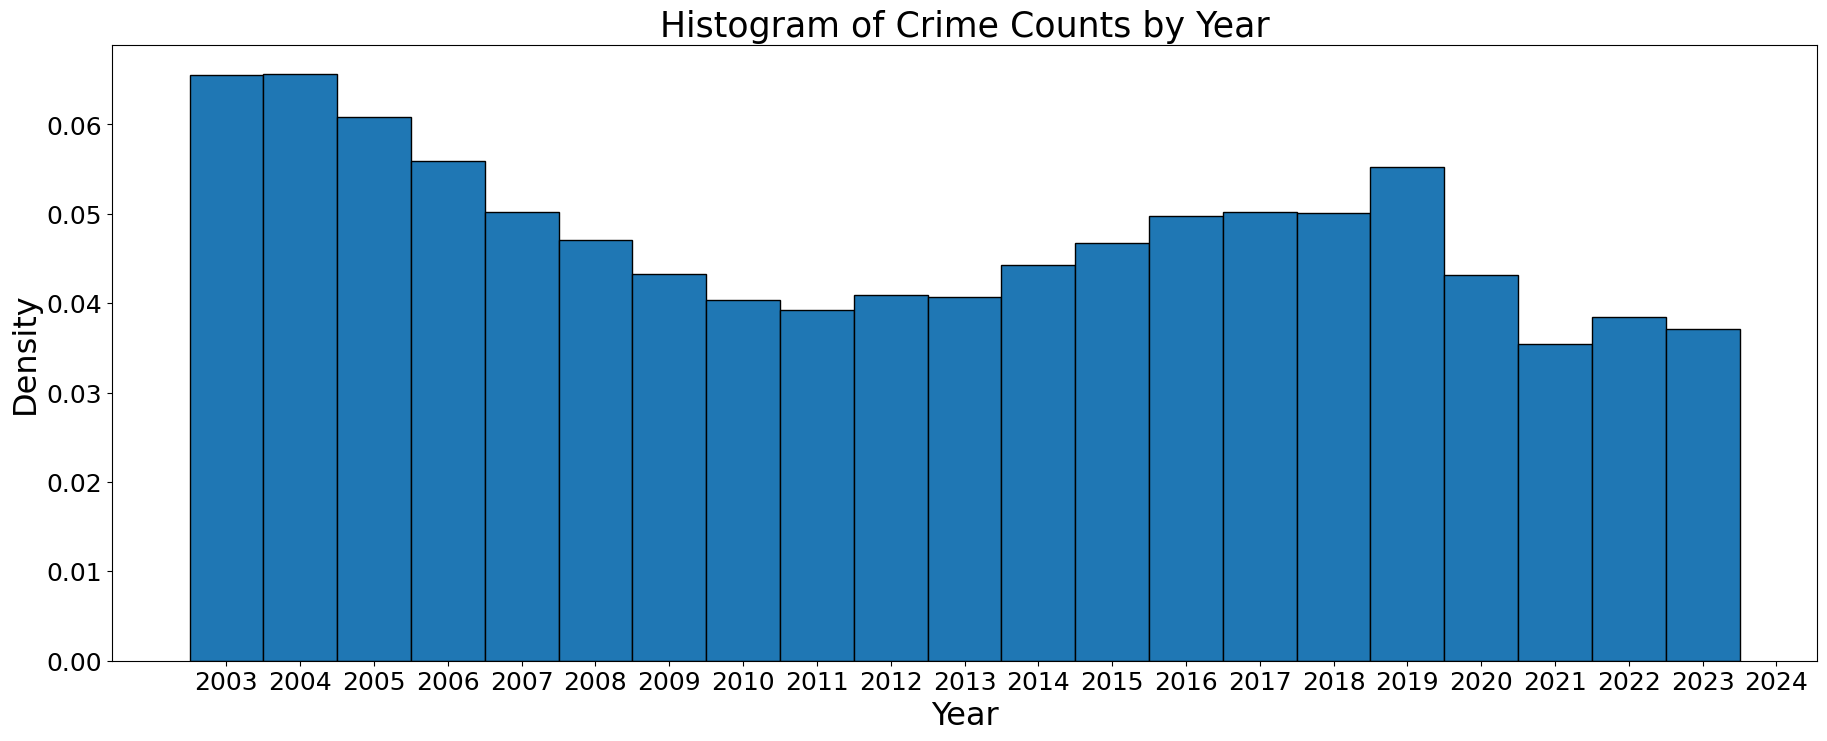

In [81]:
# Plot the histogram of crime counts by year
plt.figure(figsize=(22, 8))
year = range(df['YEAR'].min(), df['YEAR'].max() + 2)

df['YEAR'].hist(density=True, align='left', bins=year, edgecolor='black')
plt.xticks(year, fontsize=18)
plt.yticks(fontsize=18)

plt.title('Histogram of Crime Counts by Year', fontsize=25)
plt.xlabel('Year', fontsize=23)
plt.ylabel('Density', fontsize=23)
plt.grid(False)
plt.show()

Let's break down the histogram and see how the histograms for each crime type looks like:

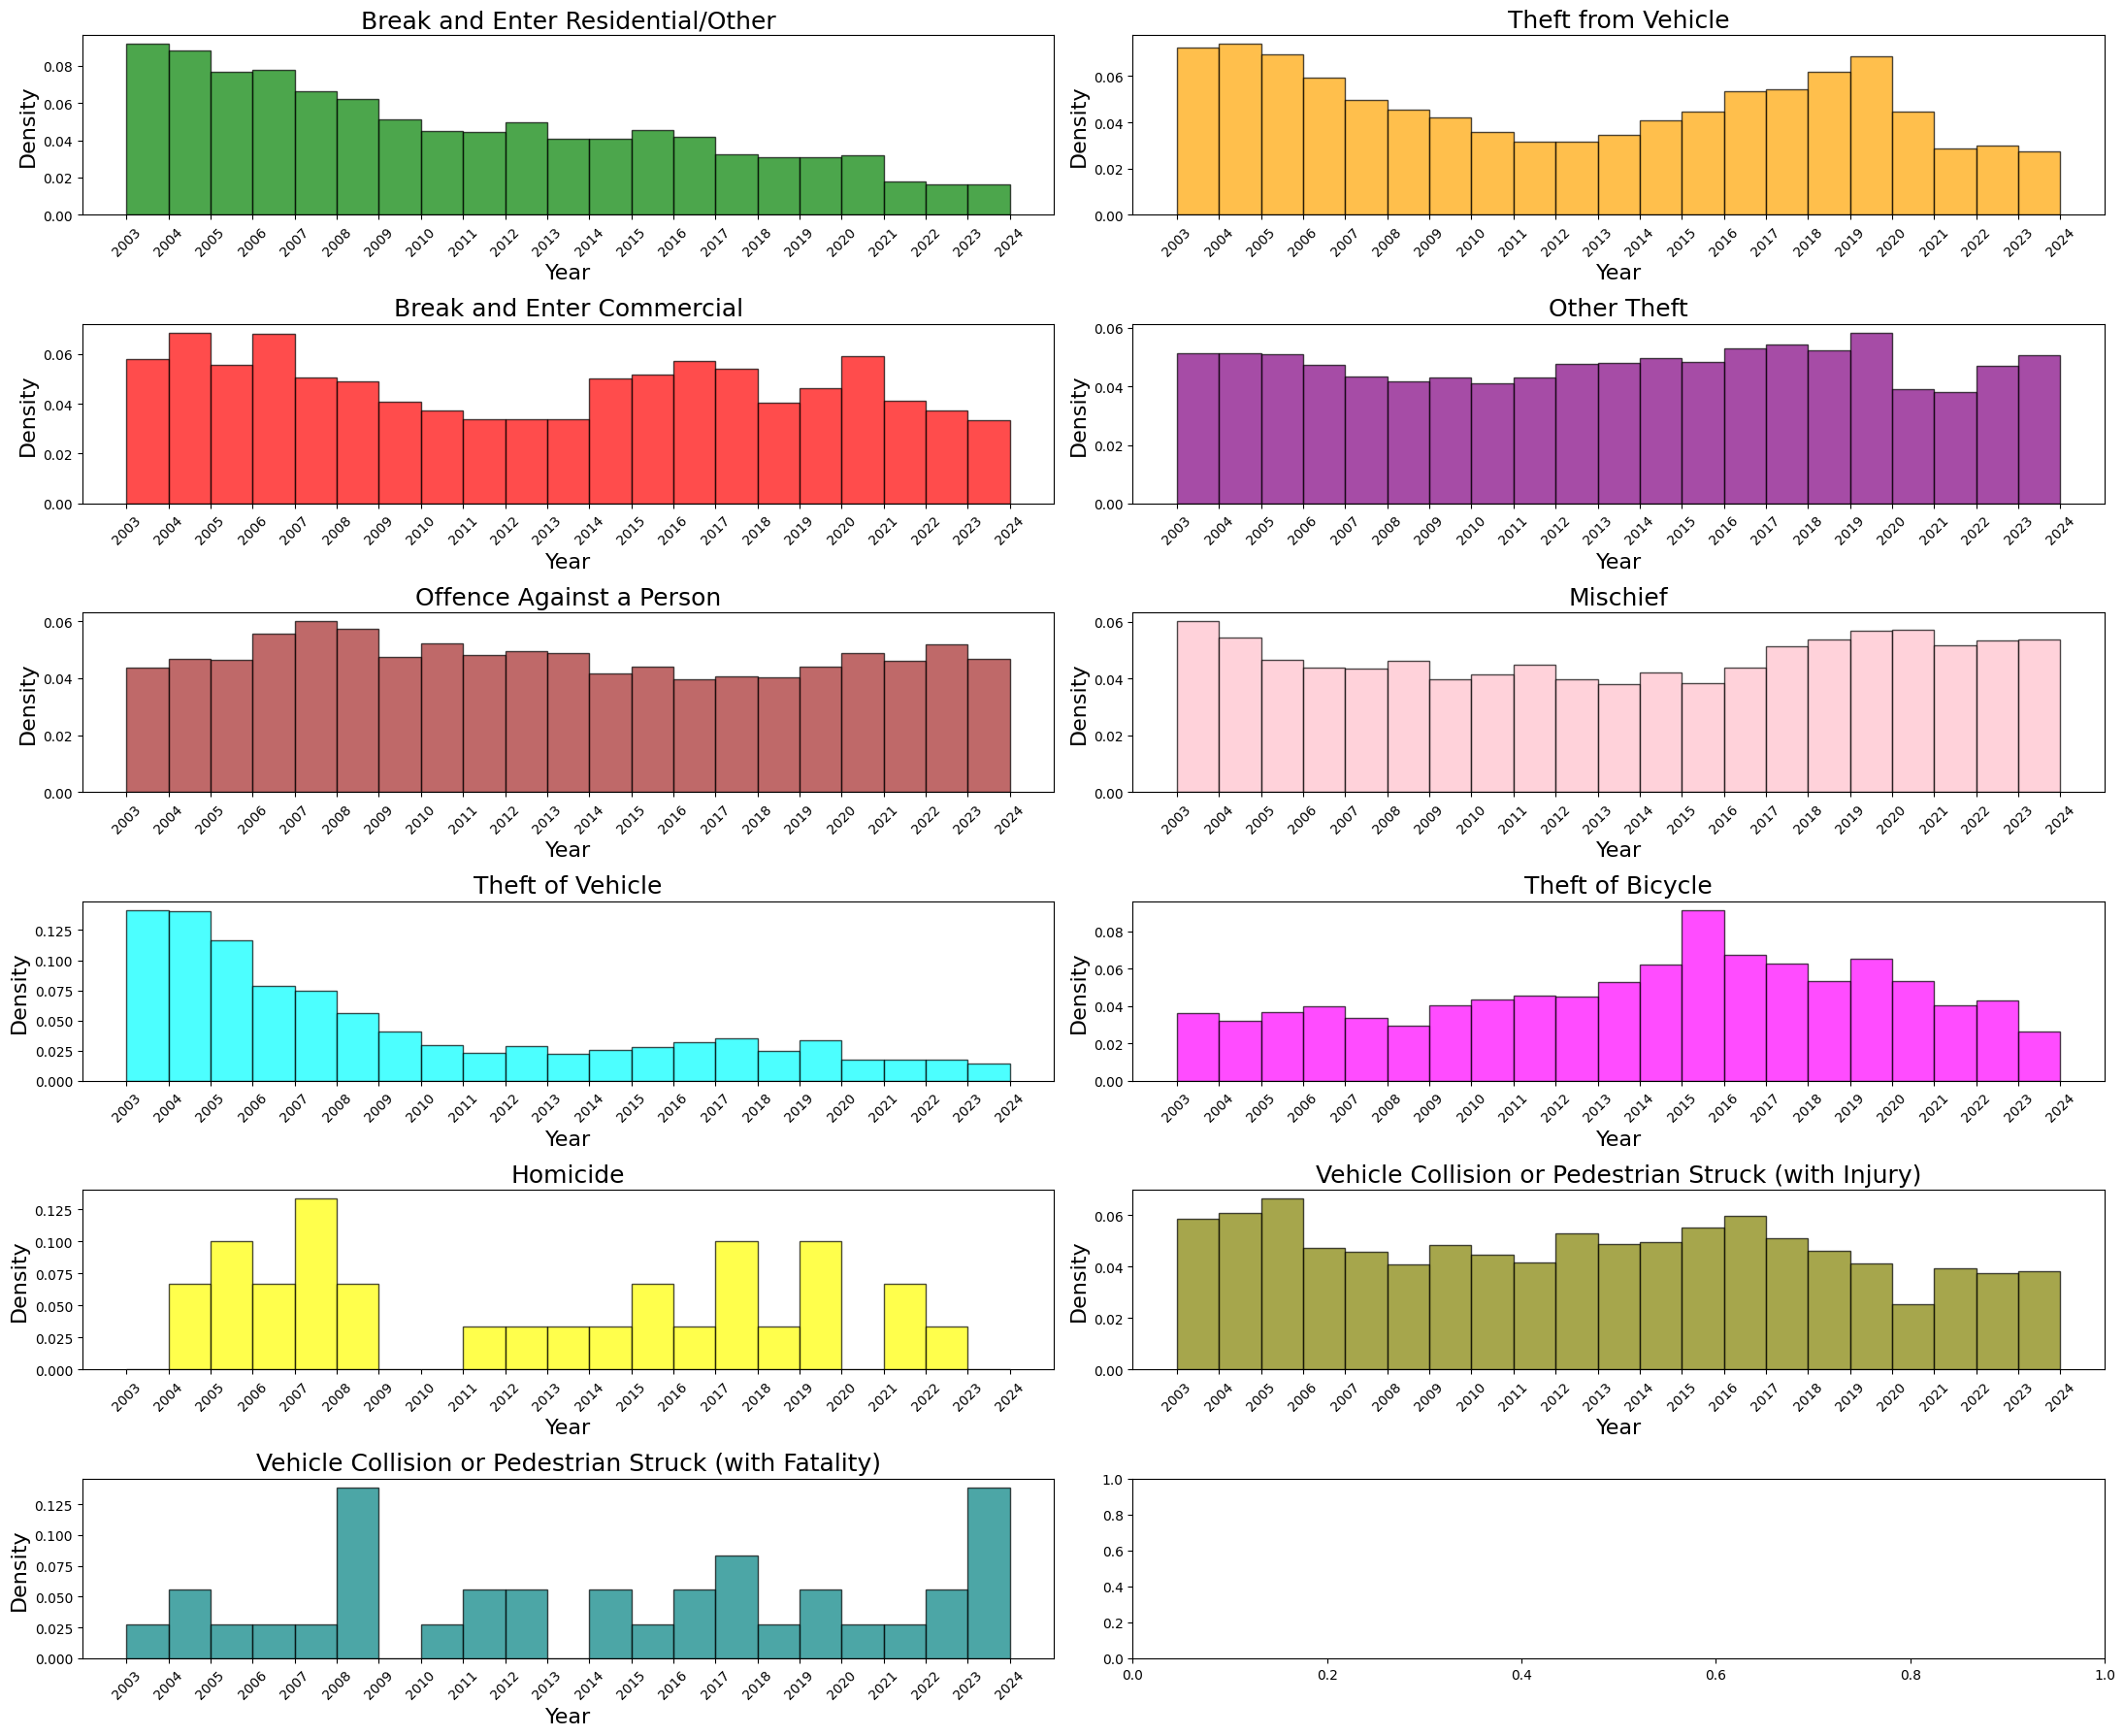

In [82]:
crime_types = df['TYPE'].unique()

colors = ['green', 'orange', 'red', 'purple', 'brown', 'pink', 'cyan', 'magenta', 'yellow', 'olive', 'teal']

num_columns = 2  

num_rows = math.ceil(len(crime_types) / num_columns)

fig, ax = plt.subplots(num_rows, num_columns, figsize=(22, 18))

# Plot histograms for each crime type
for i, (crime_type, color) in enumerate(zip(crime_types, colors)):
    crime_data = df[df['TYPE'] == crime_type]
    if len(crime_data) > 0:
        row = i // num_columns
        col = i % num_columns
        ax[row, col].hist(crime_data['YEAR'], density=True, bins=year, color=color, alpha=0.7, edgecolor='black')
        ax[row, col].set_xticks(year)
        ax[row, col].set_title(f'{crime_type}', fontsize=18)
        ax[row, col].set_xlabel('Year', fontsize=16)
        ax[row, col].set_ylabel('Density', fontsize=16)
        ax[row, col].grid(False)
        ax[row, col].tick_params(axis='x', rotation=45) 

plt.tight_layout()
plt.show()


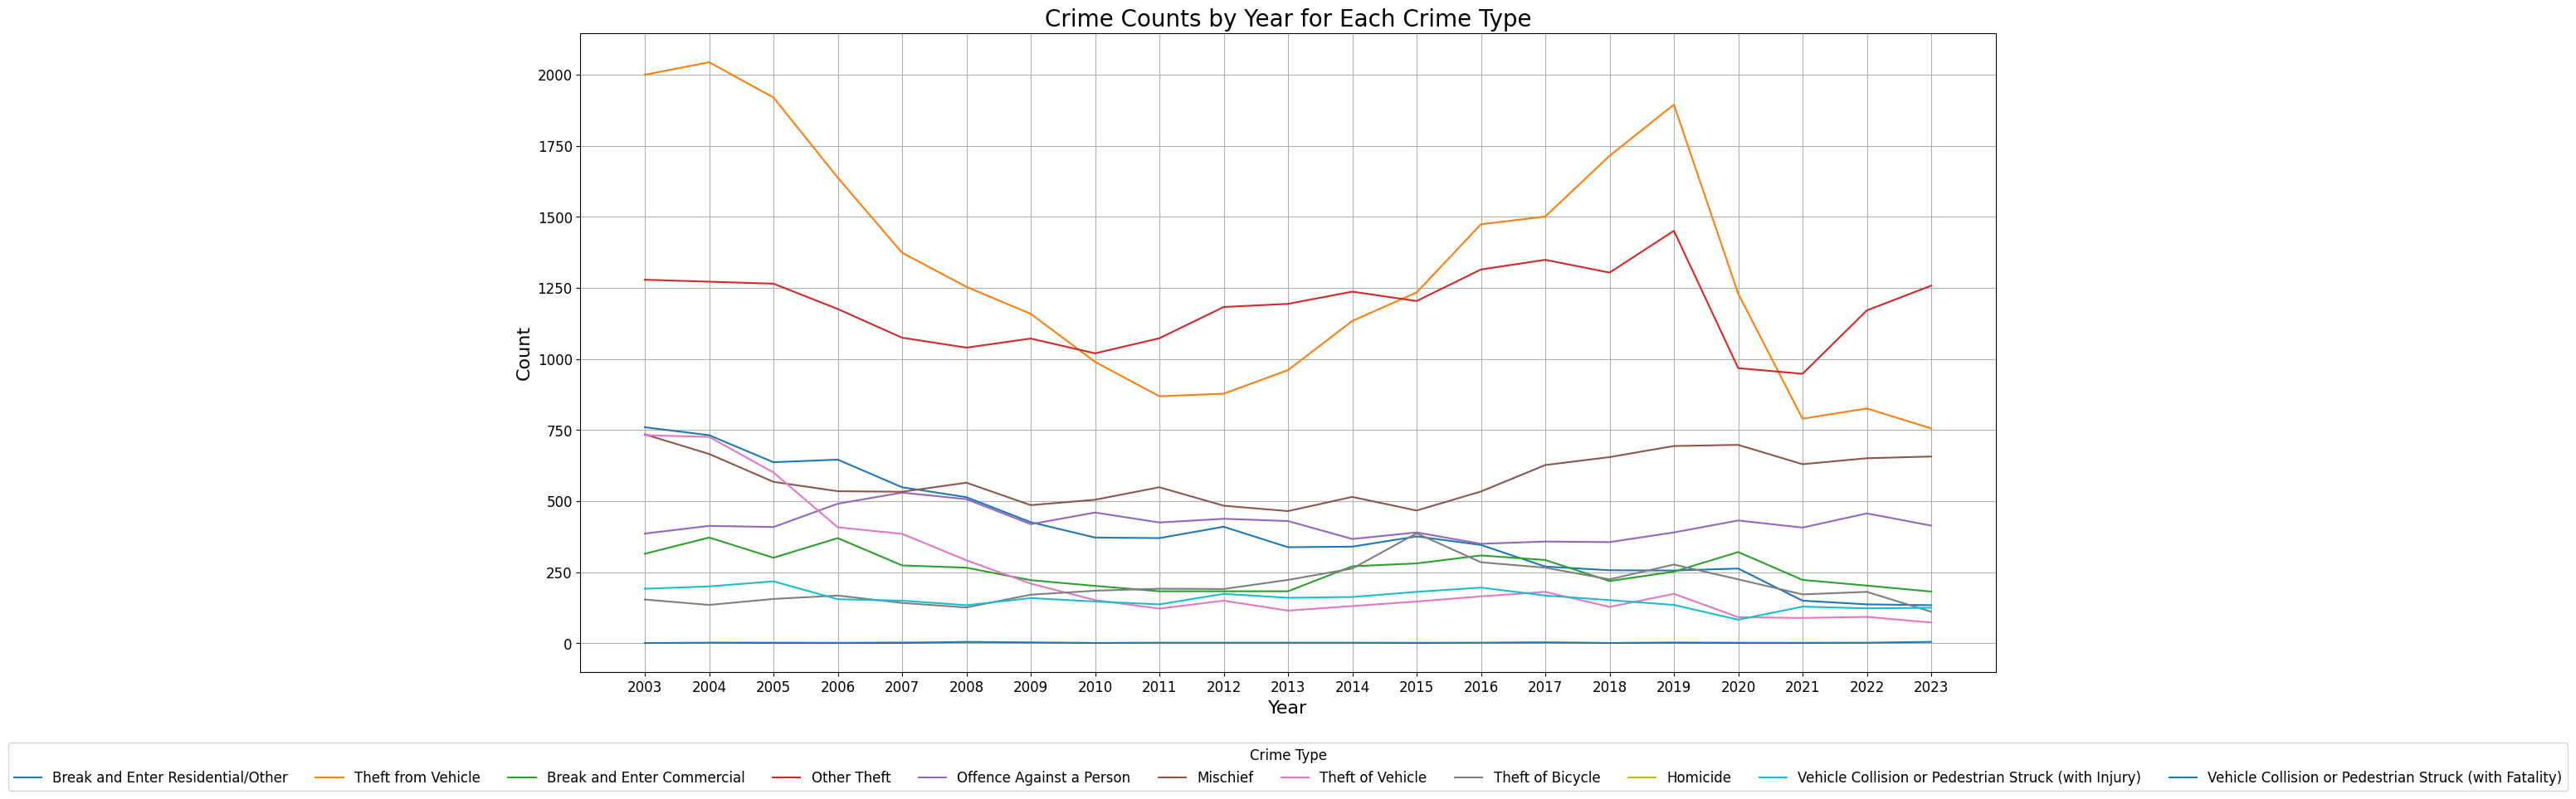

In [83]:
crime_counts = df.groupby(['TYPE', 'YEAR']).size().reset_index(name='COUNT')
uni_year = df['YEAR'].unique()

# Plot lines for each crime type
plt.figure(figsize=(22, 10))
for type in crime_types:
    data = crime_counts[crime_counts['TYPE'] == type]
    plt.plot(data['YEAR'], data['COUNT'], label=type)
    plt.xticks(uni_year)

plt.title('Crime Counts by Year for Each Crime Type', fontsize=20)
plt.xlabel('Year', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)
plt.legend(title='Crime Type', fontsize=12, title_fontsize=12, bbox_to_anchor=(0.5, -0.1), loc='upper center', ncol=len(crime_types))

plt.show()


## Model Building and Analyzing

Based on the histograms and crime counts graph for each crime type, we couldn't see obvious trending for each crime type. So we will try to fit the polynomial regression model to the dataset and observe the result.

### Polynomial Regression

Fit the polynomial regression model for each crime type from 2003 to 2023:

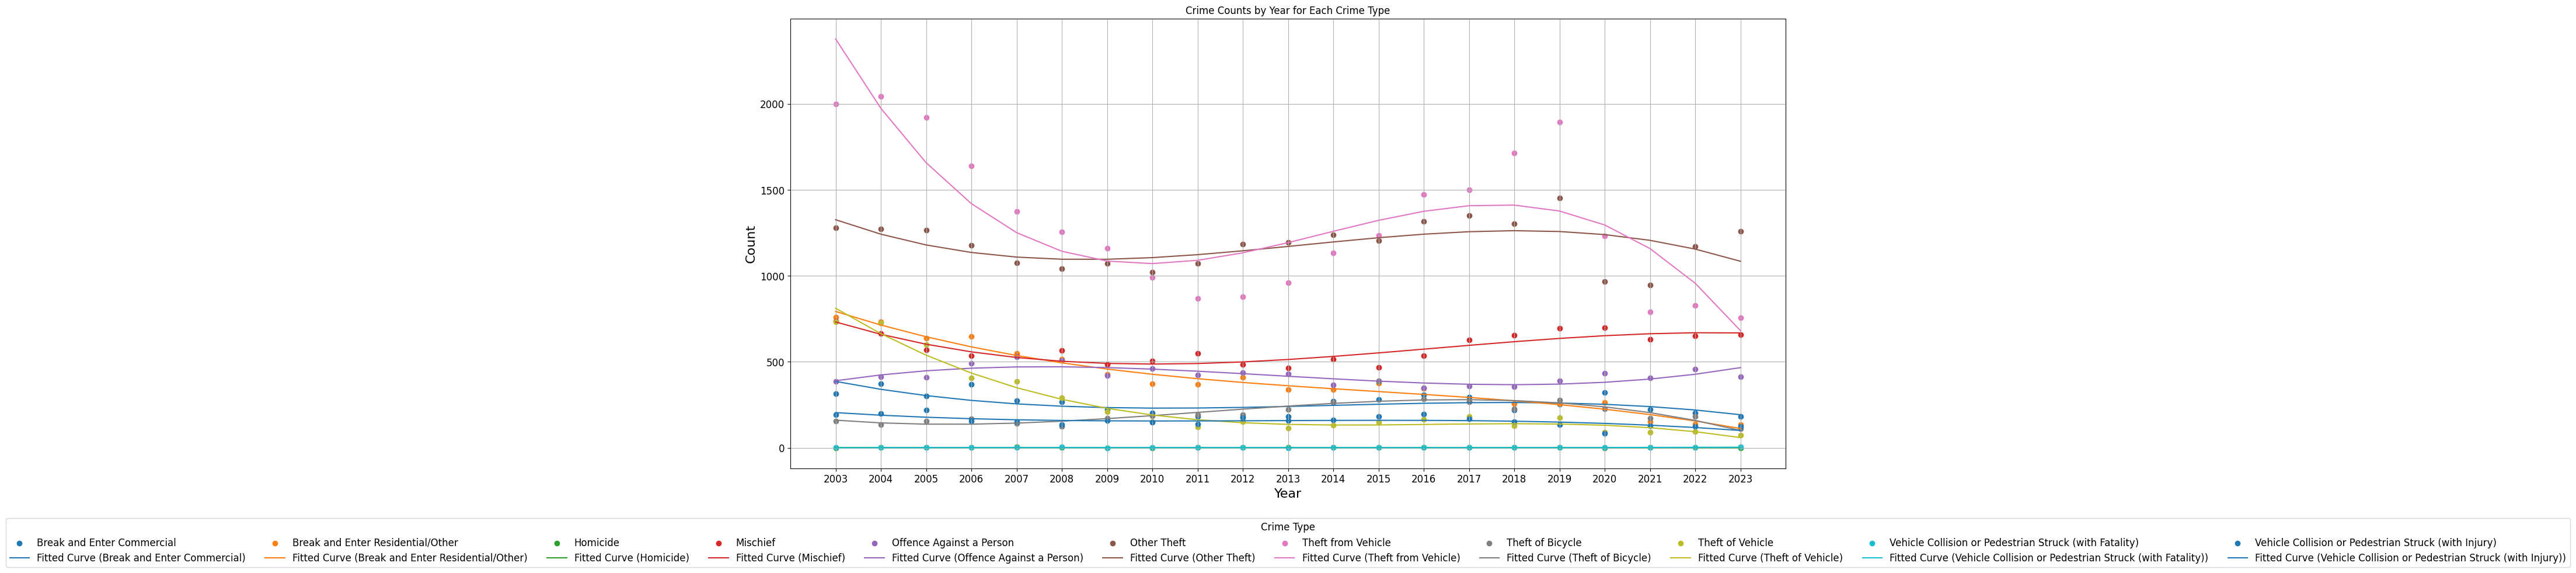

[2010 2015 2005 2007 2011 2017 2014 2020 2023 2019 2012 2021 2008 2009
 2018 2013 2016 2004 2006 2003 2022]


In [84]:
crime_pivot = crime_counts.pivot(index='TYPE', columns='YEAR', values='COUNT').fillna(0)
crime_pivot = crime_pivot.T

# Extract features (years)
X = crime_pivot.index.values.reshape(-1, 1)

models = {}

# Fit the polynomial regression models for each crime type
for crime_type in crime_pivot.columns:
    y = crime_pivot[crime_type].values
    
    poly_features = PolynomialFeatures(degree=3) # Choose degree = 3 to better fit the atual data
    X_poly = poly_features.fit_transform(X)
    
    poly_model = LinearRegression()
    poly_model.fit(X_poly, y)
    
    models[crime_type] = poly_model


# Plot the data and the fitted polynomial curve for each crime type
plt.figure(figsize=(22, 10))

for crime_type, model in models.items():

    X = crime_pivot.index.values.reshape(-1, 1)
    
    y_pred = model.predict(poly_features.fit_transform(X))
    

    plt.scatter(X, crime_pivot[crime_type], label=crime_type)
    plt.plot(X, y_pred, label=f'Fitted Curve ({crime_type})')
    

plt.title('Crime Counts by Year for Each Crime Type')
plt.xlabel('Year', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.xticks(uni_year, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)

plt.legend(title='Crime Type', fontsize=12, title_fontsize=12, bbox_to_anchor=(0.5, -0.1), loc='upper center', ncol=len(crime_types))

plt.show()
print(uni_year)

As we fitted the polynomial regression to the sample dataset, we can get the prediction counts for each crime type in 2024.

In [85]:
year_2024 = np.array([[2024]])
predictions = {}

# Store the rounded predictions amount of events into the dictionary
for crime_type, model in models.items():
    
    poly = poly_features.fit_transform(year_2024)
    
    count_2024 = round(model.predict(poly)[0])
    
    predictions[crime_type] = count_2024


for crime_type, prediction in predictions.items():
    print(f"Predicted count of '{crime_type}' crime in 2024 is {prediction}.")


Predicted count of 'Break and Enter Commercial' crime in 2024 is 157.
Predicted count of 'Break and Enter Residential/Other' crime in 2024 is 61.
Predicted count of 'Homicide' crime in 2024 is 1.
Predicted count of 'Mischief' crime in 2024 is 659.
Predicted count of 'Offence Against a Person' crime in 2024 is 516.
Predicted count of 'Other Theft' crime in 2024 is 992.
Predicted count of 'Theft from Vehicle' crime in 2024 is 324.
Predicted count of 'Theft of Bicycle' crime in 2024 is 28.
Predicted count of 'Theft of Vehicle' crime in 2024 is 13.
Predicted count of 'Vehicle Collision or Pedestrian Struck (with Fatality)' crime in 2024 is 4.
Predicted count of 'Vehicle Collision or Pedestrian Struck (with Injury)' crime in 2024 is 80.


I rounded up the predicted count into integer to better fit the reality, since it can't be a float number for events counting.

## Conclusion

The project is challenging but I learn a lot during the process. When I started the project, I was thinking about fitting the linear regression model to the dataset, but soon found out that it may not be the appropriate approach when I saw the histograms of the sample dataset. I also apply the knowledge that I learned from Math 360. It is a good learning experience for me overall.